# Global Energy Consumption Analysis (1996-2023)

This project analyzes global energy consumption patterns between 1996 and 2023 using the `energy.csv` dataset.  
The data includes annual measurements of energy production from **fossil fuels**, **nuclear**, and **renewable sources**, along with **total primary energy consumption**, **GDP**, and **population** for over 220 countries.

The analysis explores how energy consumption relates to economic development, demographic trends, and regional patterns, supported by data visualization and statistical insights.


## Load and Inspect Dataset
We begin by loading the dataset, checking its structure, and summarizing basic statistics.


In [35]:
# Load essential libraries 
library(tidyverse) 
library(dplyr) 
library(ggplot2) 
library(corrplot) 
library(VIM) 
library(scales) 
library(reshape2)
library(RColorBrewer)
library(gridExtra)

In [2]:
# Load dataset
energy <- read.csv("data/energy.csv")

# Preview the data
head(energy)


,country,year,iso_code,population,gdp,fossil_fuel,nuclear,primary_energy,renewables
,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,1996,AFG,17106600,12070125568,NA,NA,-1.000,NA
2,Afghanistan,1997,AFG,17788818,11850753024,NA,NA,6.938,NA
3,Afghanistan,1998,AFG,18493134,11692171264,NA,NA,6.752,NA
4,Afghanistan,1999,AFG,19262854,11517316096,NA,NA,6.749,NA
5,Afghanistan,2000,AFG,19542986,11283793920,NA,NA,5.914,NA
6,Afghanistan,2001,AFG,19688634,11021273088,NA,NA,4.664,NA


**Quick Overview:**
- 6,018 observations × 9 variables  
- 2 categorical (`country`, `iso_code`) and 7 numeric variables  
- Time span: 1996-2023 (28 years)  
- No duplicates or formatting inconsistencies detected

## Data Quality and Missingness

Before proceeding, we examine the completeness of the dataset to identify any data quality concerns.


In [3]:
# Count missing values per column
missing_summary <- colSums(is.na(energy))
missing_percentage <- round((missing_summary / nrow(energy)) * 100, 1)
data.frame(Missing_Values = missing_summary, Percentage = missing_percentage)


,Missing_Values,Percentage
,<dbl>,<dbl>
country,0,0.0
year,0,0.0
iso_code,0,0.0
population,41,0.7
gdp,1568,26.1
fossil_fuel,3965,65.9
nuclear,3075,51.1
primary_energy,238,4.0
renewables,3995,66.4


In [4]:
# Check structure and data types
str(energy)

'data.frame':	6018 obs. of  9 variables:
 $ country       : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ year          : int  1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 ...
 $ iso_code      : chr  "AFG" "AFG" "AFG" "AFG" ...
 $ population    : int  17106600 17788818 18493134 19262854 19542986 19688634 21000258 22645136 23553554 24411196 ...
 $ gdp           : num  1.21e+10 1.19e+10 1.17e+10 1.15e+10 1.13e+10 ...
 $ fossil_fuel   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ nuclear       : num  NA NA NA NA NA NA NA NA NA NA ...
 $ primary_energy: num  -1 6.94 6.75 6.75 5.91 ...
 $ renewables    : num  NA NA NA NA NA NA NA NA NA NA ...


In [5]:
# Summary statistics
summary(energy)

   country               year        iso_code           population       
 Length:6018        Min.   :1996   Length:6018        Min.   :1.833e+03  
 Class :character   1st Qu.:2002   Class :character   1st Qu.:7.498e+05  
 Mode  :character   Median :2009   Mode  :character   Median :5.771e+06  
                    Mean   :2009                      Mean   :3.239e+07  
                    3rd Qu.:2016                      3rd Qu.:2.102e+07  
                    Max.   :2023                      Max.   :1.429e+09  
                                                      NA's   :41         
      gdp             fossil_fuel          nuclear        primary_energy     
 Min.   :2.887e+08   Min.   :   11.57   Min.   :   0.00   Min.   :   -1.000  
 1st Qu.:2.164e+10   1st Qu.:  184.28   1st Qu.:   0.00   1st Qu.:    5.721  
 Median :6.957e+10   Median :  431.81   Median :   0.00   Median :   46.612  
 Mean   :5.340e+11   Mean   : 1529.46   Mean   :  67.12   Mean   :  663.295  
 3rd Qu.:3.269e+11

In [6]:
# Dimensions (rows, columns)
dim(energy)

[1] 6018    9


 Variables sorted by number of missings: 
       Variable       Count
     renewables 0.663841808
    fossil_fuel 0.658856763
        nuclear 0.510967099
            gdp 0.260551678
 primary_energy 0.039548023
     population 0.006812895
        country 0.000000000
           year 0.000000000
       iso_code 0.000000000


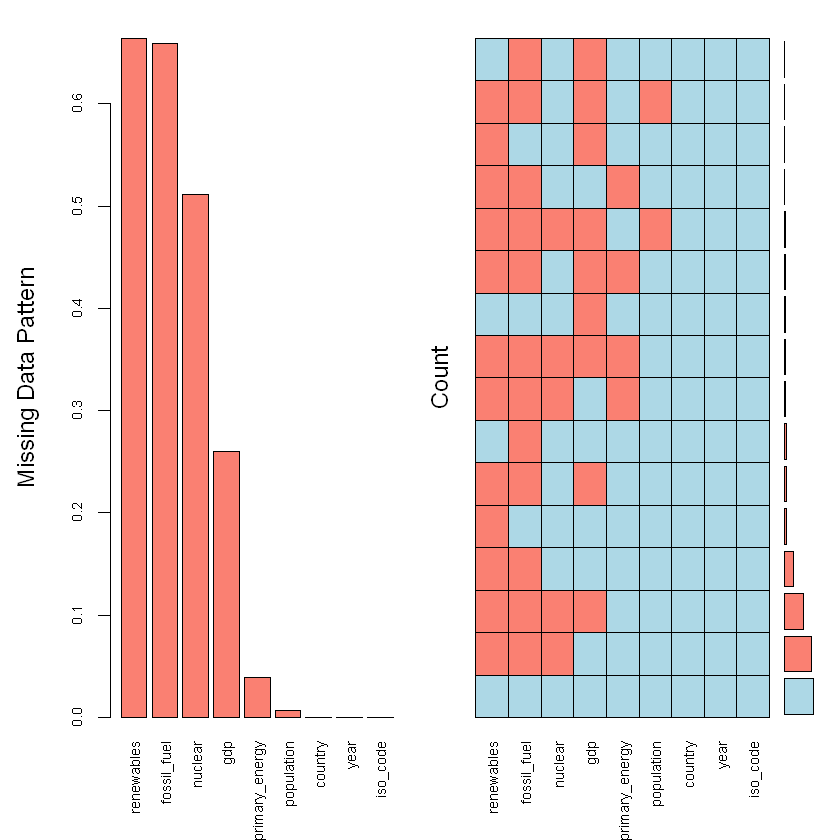

In [7]:
# Visualize missing data pattern
suppressWarnings(aggr(energy, col = c("lightblue", "salmon"),
     numbers = TRUE, sortVars = TRUE,
     labels = names(energy), cex.axis = 0.7,
     gap = 3, ylab = c("Missing Data Pattern", "Count")))


**Observations:**
- ~23.8% of total cells contain missing values  
- Missingness is concentrated in GDP (26%), fossil fuels (65.9%), renewables (66.4%), and nuclear (51%)  
- Country and ISO code columns are complete  
- Missingness is clustered across related variables, suggesting a country-level reporting bias rather than random gaps


## Variable Distributions

We visualize numerical variables to understand their spread and detect any skewness or zero-inflation patterns.


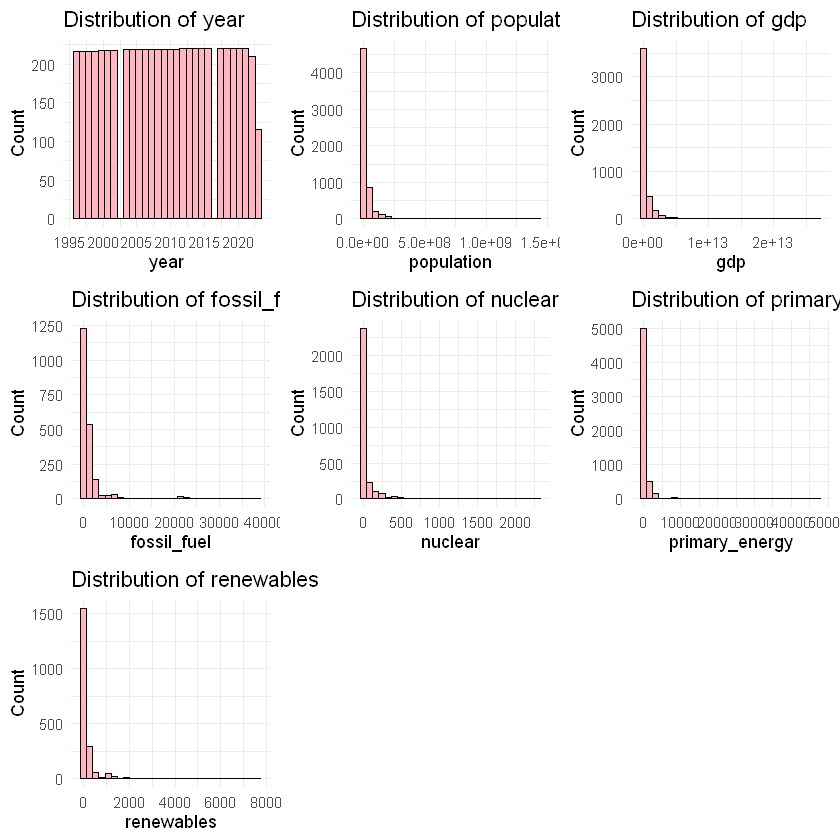

In [8]:
# Suppress warnings from the entire plotting block
suppressWarnings({
  # Select numeric columns
  numeric_vars <- energy %>% select_if(is.numeric)

  # Create histograms for all numeric variables
  plot_list <- lapply(names(numeric_vars), function(var) {
    ggplot(energy, aes_string(x = var)) +
      geom_histogram(fill = "lightpink", color = "black", bins = 30) +
      theme_minimal() +
      labs(title = paste("Distribution of", var), x = var, y = "Count")
  })

  # Arrange all plots in a grid
  do.call(grid.arrange, c(plot_list, ncol = 3))
})


**Insights:**
- GDP and population are highly right-skewed - large economies dominate  
- Nuclear and renewables show heavy zero-inflation, reflecting limited adoption in many countries  
- Fossil fuels and primary energy show nearly identical patterns, indicating dependency



## Relationships Between Key Variables

Next, we explore correlations among economic and energy variables to assess how energy demand scales with development.



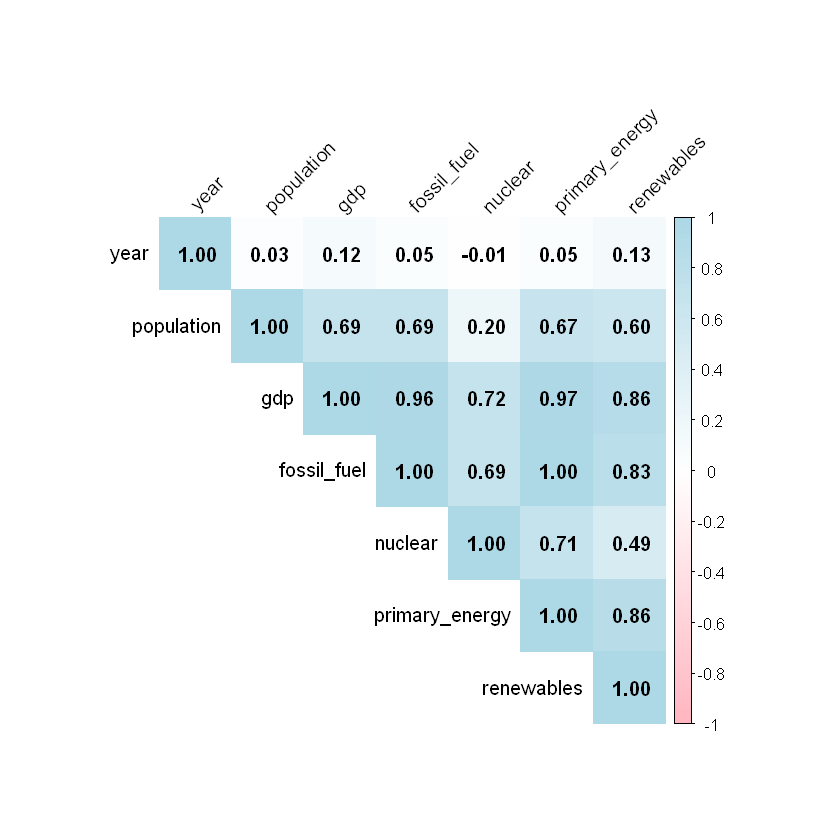

In [9]:
# Compute correlation matrix for numeric variables
corr_matrix <- cor(na.omit(numeric_vars), use = "pairwise.complete.obs")

# Correlation heatmap
corrplot(corr_matrix, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45,
         addCoef.col = "black",
         col = colorRampPalette(c("lightpink", "white", "lightblue"))(100))


**Findings:**
- GDP and total primary energy show a very strong positive correlation (~0.97)  
- Fossil fuels strongly correlate with total energy (~0.83), confirming fossil dominance  
- Renewables and nuclear display weaker associations, driven by differing national policies and infrastructure levels 

The dataset is structurally consistent but shows substantial missingness and right-skewed variables.  
These issues appear more prominent in lower-income countries - the next section focuses on understanding data quality among **low-GDP nations** to identify potential reporting biases.


---
### Data Quality Assessment: Low-GDP Countries

Building on the initial data overview, this section focuses on the **data quality among low-GDP countries** - those whose GDP values fall **below the first quartile (Q1)** of the global distribution.  
Analyzing this subgroup helps uncover whether economic development influences data completeness and reporting reliability in global energy statistics.


In [10]:
# Compute the first quartile of GDP
gdp_q1 <- quantile(energy$gdp, 0.25, na.rm = TRUE)
gdp_q1

# Filter dataset for low-GDP countries
low_gdp_data <- subset(energy, gdp < gdp_q1)

# Check dimensions
dim(low_gdp_data)


25% 
21640312320

[1] 1113    9

**Overview:**  
The subset includes approximately **1,113 observations** across **9 variables**.  
These represent low-income nations where data collection may be limited by resource constraints or inconsistent energy reporting systems.

In [11]:
# Summary of missing values in low-GDP dataset
missing_summary_low <- colSums(is.na(low_gdp_data))
missing_percentage_low <- round((missing_summary_low / nrow(low_gdp_data)) * 100, 1)
data.frame(Variable = names(missing_summary_low),
           Missing_Values = missing_summary_low,
           Percentage = missing_percentage_low)


,Variable,Missing_Values,Percentage
,<chr>,<dbl>,<dbl>
country,country,0,0.0
year,year,0,0.0
iso_code,iso_code,0,0.0
population,population,0,0.0
gdp,gdp,0,0.0
fossil_fuel,fossil_fuel,1091,98.0
nuclear,nuclear,936,84.1
primary_energy,primary_energy,29,2.6
renewables,renewables,1056,94.9


**Observation:**  
- Around **31.1%** of all cells are missing.  
- The worst-affected variables are:  
  - **Fossil fuels:** ~98% missing  
  - **Renewables:** ~94.9% missing  
  - **Nuclear:** ~84.1% missing  
  - **Primary energy:** ~2.6% missing  

This pattern indicates a **systematic lack of data** for low-income countries, especially in energy production-related variables.



 Variables sorted by number of missings: 
       Variable      Count
    fossil_fuel 0.98023360
     renewables 0.94878706
        nuclear 0.84097035
 primary_energy 0.02605571
        country 0.00000000
           year 0.00000000
       iso_code 0.00000000
     population 0.00000000
            gdp 0.00000000


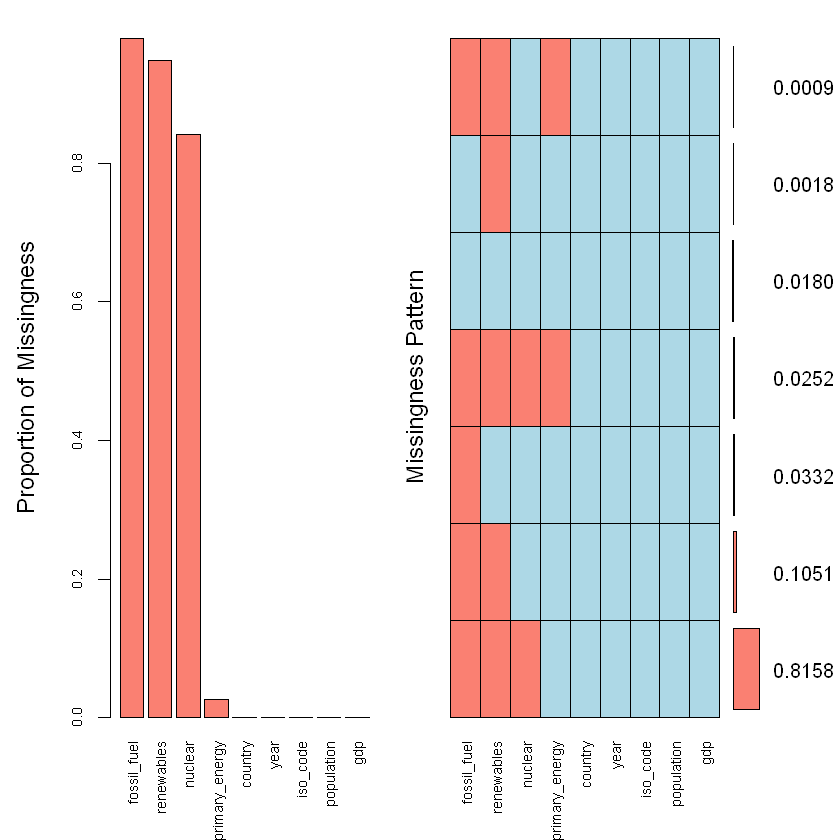

In [12]:
# Visualize missingness in the low-GDP subset
aggr(low_gdp_data, col = c("lightblue", "salmon"),
     numbers = TRUE, sortVars = TRUE, labels = names(low_gdp_data),
     cex.axis = 0.7, gap = 3, 
     ylab = c("Proportion of Missingness", "Missingness Pattern"))


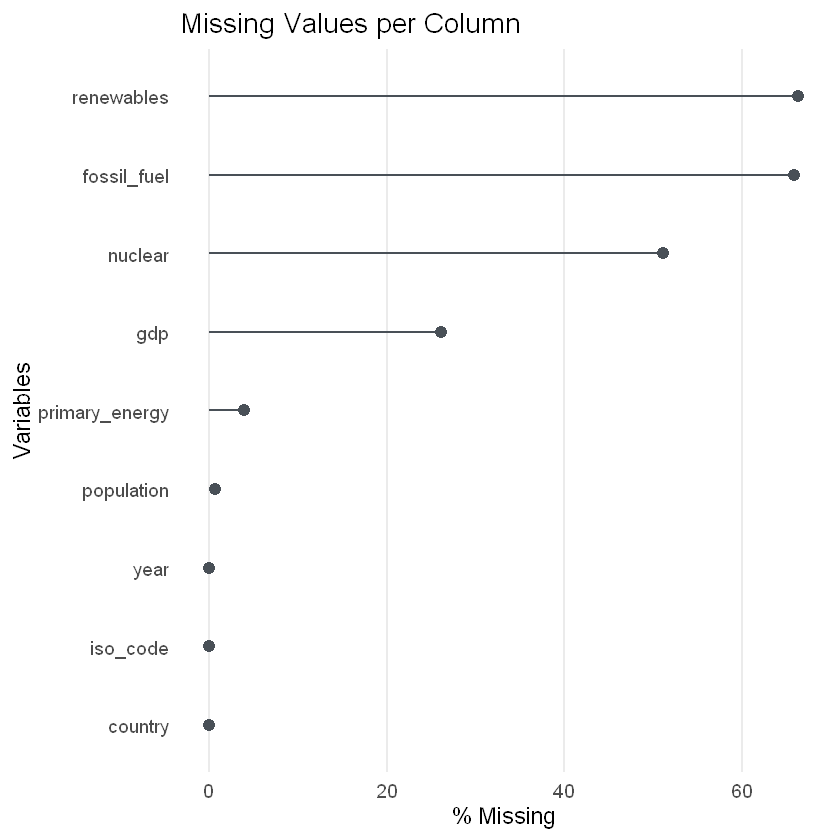

In [13]:
# Calculate the percentage of missing values and reshape the data into a long format
missing_data_for_plot <- energy %>%
  summarise(across(everything(), .fns = ~ (sum(is.na(.)) / n()) * 100)) %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Percentage")

ggplot(missing_data_for_plot, aes(x = Percentage, y = fct_reorder(Variable, Percentage))) +
  
  geom_segment(
    aes(x = 0, xend = Percentage, yend = Variable), 
    color = "#495057", 
    linewidth = 0.75
  ) +
  
  geom_point(color = "#495057", size = 3) +
  
  labs(
    title = "Missing Values per Column",
    x = "% Missing",
    y = "Variables"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    panel.grid.major.y = element_blank(), 
    panel.grid.minor.x = element_blank() 
  )

**Interpretation:**  
The visualization confirms heavy missingness across multiple energy variables, especially fossil fuels and renewables.  
Such a pattern suggests incomplete data collection or underreporting from low-GDP nations, possibly due to resource or infrastructure limitations.



#### Variability and Outlier Detection

In [14]:
# Check for near-constant or low-variance variables
apply(low_gdp_data %>% select_if(is.numeric), 2, function(x) var(x, na.rm = TRUE))


year     population            gdp    fossil_fuel        nuclear 
  5.596886e+01   2.507653e+13   4.480760e+19   1.172195e+03   0.000000e+00 
primary_energy     renewables 
  4.462345e+02   4.202369e+02

**Observation:**  
- **Nuclear energy** shows near-zero variance - nearly all values are identical or zero, making it analytically uninformative.  
- **Primary energy** and **population** retain measurable variation suitable for further modeling.


In [15]:
# Detect outliers using the IQR method
outliers_low <- sapply(low_gdp_data %>% select_if(is.numeric), function(x) {
  if (all(is.na(x))) return(NA)
  qnt <- quantile(x, probs = c(0.25, 0.75), na.rm = TRUE)
  IQR_val <- qnt[2] - qnt[1]
  lower <- qnt[1] - 1.5 * IQR_val
  upper <- qnt[2] + 1.5 * IQR_val
  sum(x < lower | x > upper, na.rm = TRUE)
})
outliers_low


year     population            gdp    fossil_fuel        nuclear 
             0             29              0              3              0 
primary_energy     renewables 
            93              0

**Findings:**
- **Population:** 29 outliers - countries with large populations but very low GDP (e.g., India, Nigeria).  
- **Fossil fuels:** 3 outliers - possibly oil exporters with disproportionate energy output.  
- **GDP** and **renewables:** no significant outliers detected. 
 
Outliers highlight economic-energy imbalances that may distort global correlations if not handled carefully.

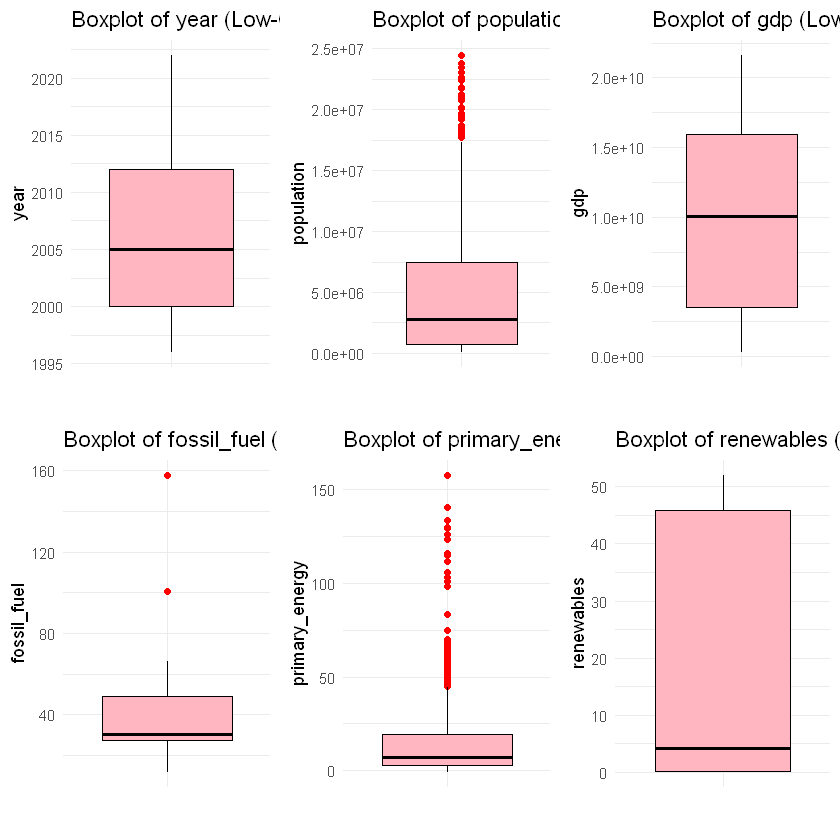

In [16]:
# Quick visual check for outliers using boxplots (warnings suppressed and robust to NA/constant vars)
suppressWarnings({
  num_low <- low_gdp_data %>%
    select_if(is.numeric) %>%
    select(where(~ sum(!is.na(.)) > 0))  # drop columns that are all NA
  
  # Filter out variables with 0 variance (constant)
  num_low <- num_low[, sapply(num_low, function(x) var(x, na.rm = TRUE) > 0), drop = FALSE]
  
  # Create a boxplot for each numeric variable
  plot_list_low <- lapply(names(num_low), function(var) {
    ggplot(low_gdp_data, aes_string(x = "''", y = var)) +   # ensure a single valid expression
      geom_boxplot(fill = "lightpink", color = "black", outlier.colour = "red") +
      theme_minimal() +
      labs(
        title = paste("Boxplot of", var, "(Low-GDP Countries)"),
        y = var, x = ""
      )
  })
  
  # Arrange plots in grid
  if (length(plot_list_low) > 0) {
    do.call(grid.arrange, c(plot_list_low, ncol = 3))
  } else {
    message("No valid numeric variables to plot.")
  }
})


**Interpretation:**  
Visual inspection confirms a few extreme points in **population** and **fossil fuel** usage, but most variables exhibit compressed ranges - reflecting limited diversity and industrial activity among low-income nations.

#### Data Consistency and Duplicates

In [17]:
# Check for duplicates
sum(duplicated(low_gdp_data))


[1] 0

**Result:**  
No duplicates detected, indicating data integrity is maintained within this subset.


#### Interpretation & Insights

| Aspect | Observation |
|--------|--------------|
| Dataset Size | 1,113 rows × 9 columns |
| Missingness | 31.1% overall; fossil, nuclear, and renewables most affected |
| Outliers | 29 in population, 3 in fossil fuels |
| Constant Variables | Nuclear nearly constant (very low variance) |
| Data Quality | Poor, with significant missingness and uneven reporting |

**Conclusion:**  
Low-GDP countries exhibit clear **data quality challenges** - high missingness, low variability in energy reporting, and sporadic outliers.  
These findings reveal structural limitations in global energy reporting systems, where less developed economies often lack the infrastructure or capacity to measure and disclose energy data accurately.

In the next section, we narrow the focus to **global energy sourcing in 2010**, connecting data reliability with real-world energy patterns across regions.




---
### Global Energy Landscape - Focus Year: 2010

To understand global energy sourcing at a key turning point, this section isolates data for **2010** - a year that marked accelerating renewable growth and post-recession industrial recovery.

We analyze the **composition of primary energy** across countries and regions, exploring dependencies among fossil fuels, nuclear, and renewables.

In [18]:
# Filter data for the year 2010
energy_2010 <- subset(energy, year == 2010)

# Check structure and basic summary
dim(energy_2010)
summary(energy_2010)


[1] 219   9

   country               year        iso_code           population       
 Length:219         Min.   :2010   Length:219         Min.   :1.838e+03  
 Class :character   1st Qu.:2010   Class :character   1st Qu.:7.161e+05  
 Mode  :character   Median :2010   Mode  :character   Median :5.812e+06  
                    Mean   :2010                      Mean   :3.203e+07  
                    3rd Qu.:2010                      3rd Qu.:2.158e+07  
                    Max.   :2010                      Max.   :1.348e+09  
                                                      NA's   :1          
      gdp             fossil_fuel          nuclear        primary_energy     
 Min.   :5.444e+08   Min.   :   27.15   Min.   :   0.00   Min.   :    0.000  
 1st Qu.:2.258e+10   1st Qu.:  220.53   1st Qu.:   0.00   1st Qu.:    7.265  
 Median :8.130e+10   Median :  438.49   Median :   0.00   Median :   46.129  
 Mean   :5.449e+11   Mean   : 1602.35   Mean   :  70.16   Mean   :  652.337  
 3rd Qu.:3.388e+11

**Observation:**  
The dataset for **2010** includes all countries (≈ 220), with full coverage across energy variables where data is available.  
This subset allows comparison of energy sourcing patterns across different economic and regional contexts.


In [19]:
# Remove rows with missing primary energy to ensure consistency
energy_2010 <- energy_2010 %>% filter(!is.na(primary_energy))

# Calculate shares (proportion of each energy source in total consumption)
energy_2010 <- energy_2010 %>%
  mutate(
    fossil_share = (fossil_fuel / primary_energy) * 100,
    nuclear_share = (nuclear / primary_energy) * 100,
    renewables_share = (renewables / primary_energy) * 100
  )

# Replace infinite or NaN values
energy_2010 <- energy_2010 %>% mutate(across(ends_with("_share"), ~ ifelse(is.na(.) | is.infinite(.), 0, .)))

head(energy_2010[, c("country", "fossil_share", "nuclear_share", "renewables_share")])


,country,fossil_share,nuclear_share,renewables_share
,<chr>,<dbl>,<dbl>,<dbl>
1,Afghanistan,0.00000,0,0.0000000
2,Albania,0.00000,0,0.0000000
3,Algeria,99.88474,0,0.1150355
4,American Samoa,0.00000,0,0.0000000
5,Angola,0.00000,0,0.0000000
6,Antarctica,0.00000,0,0.0000000


**Note:**  
These computed proportions represent each country’s **energy mix composition in 2010** - i.e., the percentage contribution of fossil, nuclear, and renewables to total energy consumption.


#### Relationship Between Energy Sources

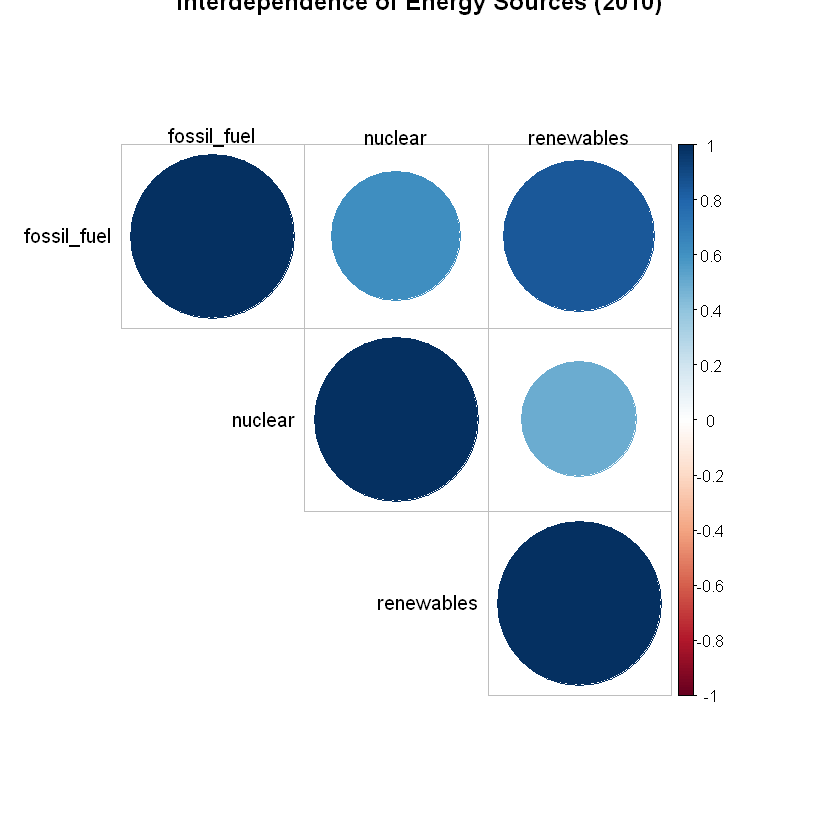

In [20]:
corrplot(
  cor(energy_2010[, c("fossil_fuel", "nuclear", "renewables")], use = "pairwise.complete.obs"),
  method = "circle", type = "upper",
  tl.col = "black", tl.srt = 0, title = "Interdependence of Energy Sources (2010)"
)


#### Global Energy Composition

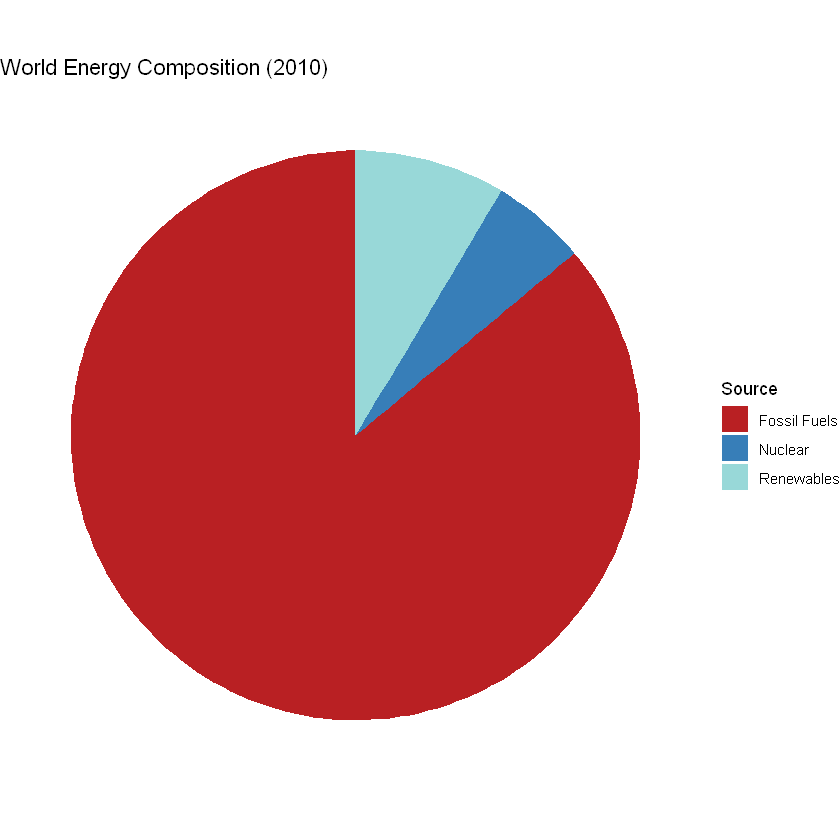

In [21]:
# Aggregate worldwide totals
world_totals_2010 <- energy_2010 %>%
  summarise(
    `Fossil Fuels` = sum(fossil_fuel, na.rm = TRUE),
    `Nuclear` = sum(nuclear, na.rm = TRUE),
    `Renewables` = sum(renewables, na.rm = TRUE)
  ) %>%
  pivot_longer(everything(), names_to = "Source", values_to = "Consumption")

# Pie chart
ggplot(world_totals_2010, aes(x = "", y = Consumption, fill = Source)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  scale_fill_manual(values = c("#b92023ff", "#377eb8", "#98d8d8")) +
  theme_void() +
  labs(title = "World Energy Composition (2010)")


Globally, **fossil fuels account for over 80%** of total energy use in 2010, reaffirming their dominance in the pre-renewable boom decade.



#### Regional Energy Mix

Warning message:
"There was 1 warning in `summarise()`.
ℹ In argument: `across(ends_with("_share"), mean, na.rm = TRUE)`.
ℹ In group 1: `region = "Asia"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


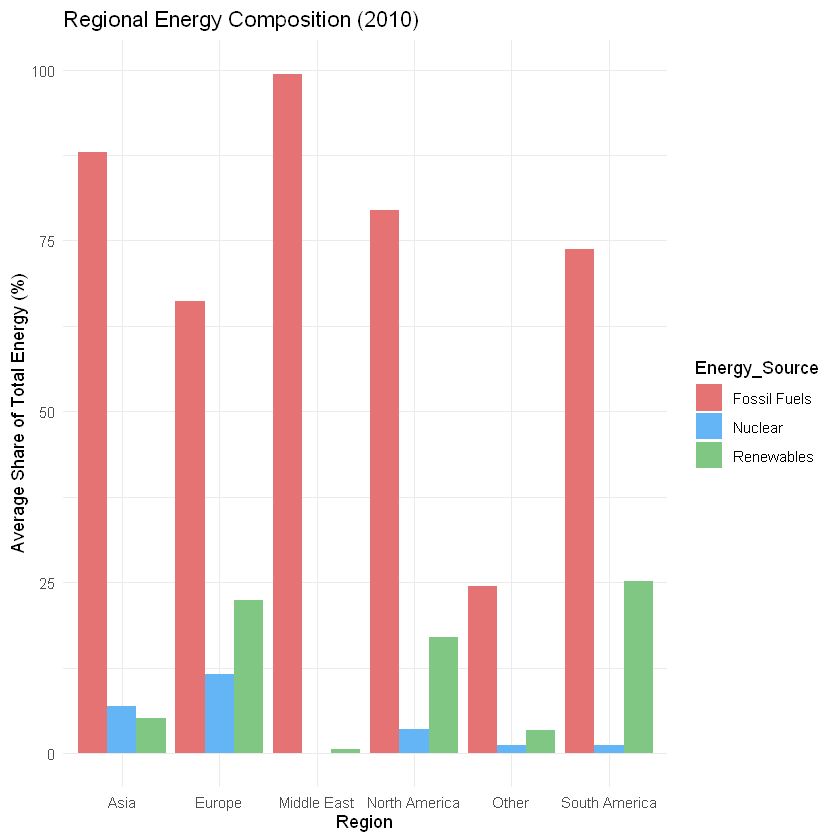

In [22]:
# Simple region mapping and aggregation
energy_2010 <- energy_2010 %>%
  mutate(region = case_when(
    country %in% c("China", "India", "Japan", "South Korea") ~ "Asia",
    country %in% c("France", "Germany", "UK", "Italy", "Norway", "Spain") ~ "Europe",
    country %in% c("USA", "Canada", "Mexico") ~ "North America",
    country %in% c("Brazil", "Argentina", "Chile") ~ "South America",
    country %in% c("Saudi Arabia", "Iran", "UAE") ~ "Middle East",
    TRUE ~ "Other"
  ))

region_summary <- energy_2010 %>%
  group_by(region) %>%
  summarise(across(ends_with("_share"), mean, na.rm = TRUE)) %>%
  pivot_longer(-region, names_to = "Energy_Source", values_to = "Share")

suppressWarnings({ggplot(region_summary, aes(x = region, y = Share, fill = Energy_Source)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("#e57373", "#64b5f6", "#81c784"),
                    labels = c("Fossil Fuels", "Nuclear", "Renewables")) +
  labs(title = "Regional Energy Composition (2010)",
       x = "Region", y = "Average Share of Total Energy (%)") +
  theme_minimal()})


**Regional patterns reveal clear contrasts:**
- **Asia** - Highly fossil-dependent, led by China and India.  
- **Europe** - More balanced; nuclear significant in France, renewables emerging in Norway and Spain.  
- **North America** - Mix of fossil and nuclear; renewables minor in 2010.  
- **South America** - Higher renewable share from hydroelectric sources.  
- **Middle East** - Near-exclusive reliance on fossil fuels.

--- 
## Linking Energy Use with Economy and Population
Having understood the 2010 landscape, we now explore how **economic scale and population** influence total energy consumption across all years (1996–2023).


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."


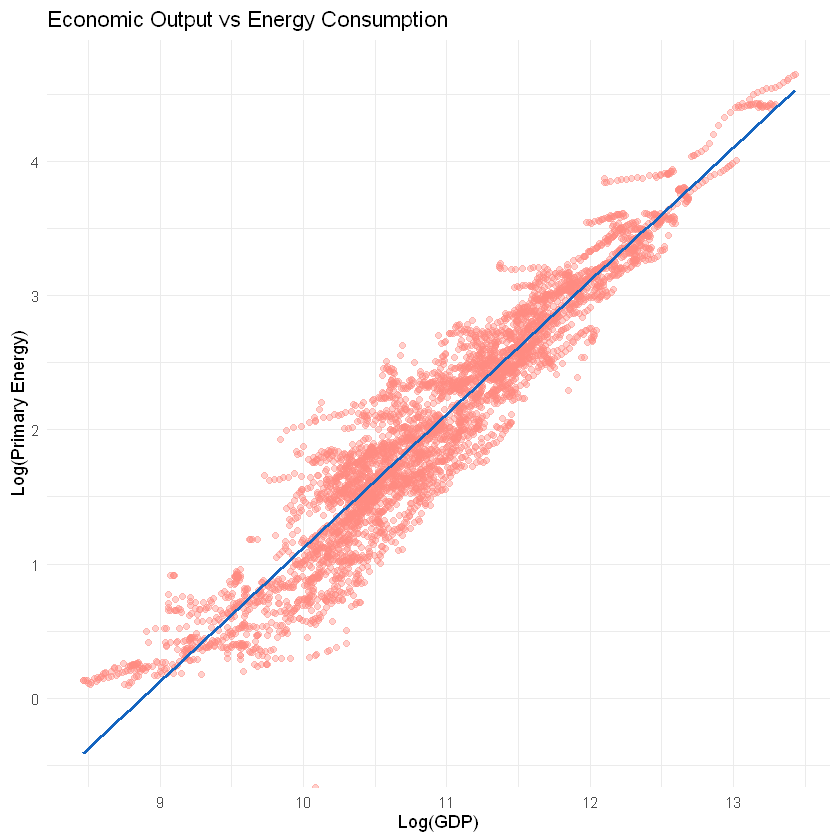

In [23]:
energy_econ <- energy %>%
  filter(!is.na(primary_energy), !is.na(gdp), !is.na(population)) %>%
  mutate(
    log_gdp = log10(gdp + 1),
    log_population = log10(population + 1),
    log_energy = log10(primary_energy + 1)
  )

ggplot(energy_econ, aes(x = log_gdp, y = log_energy)) +
  geom_point(alpha = 0.4, color = "#FF8A80") +
  geom_smooth(method = "lm", se = FALSE, color = "#1565C0") +
  theme_minimal() +
  labs(title = "Economic Output vs Energy Consumption",
       x = "Log(GDP)", y = "Log(Primary Energy)")

Energy demand rises sharply with GDP, but the slope flattens among the wealthiest countries - evidence of efficiency gains and technological maturity.

#### Population and Energy Demand

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."


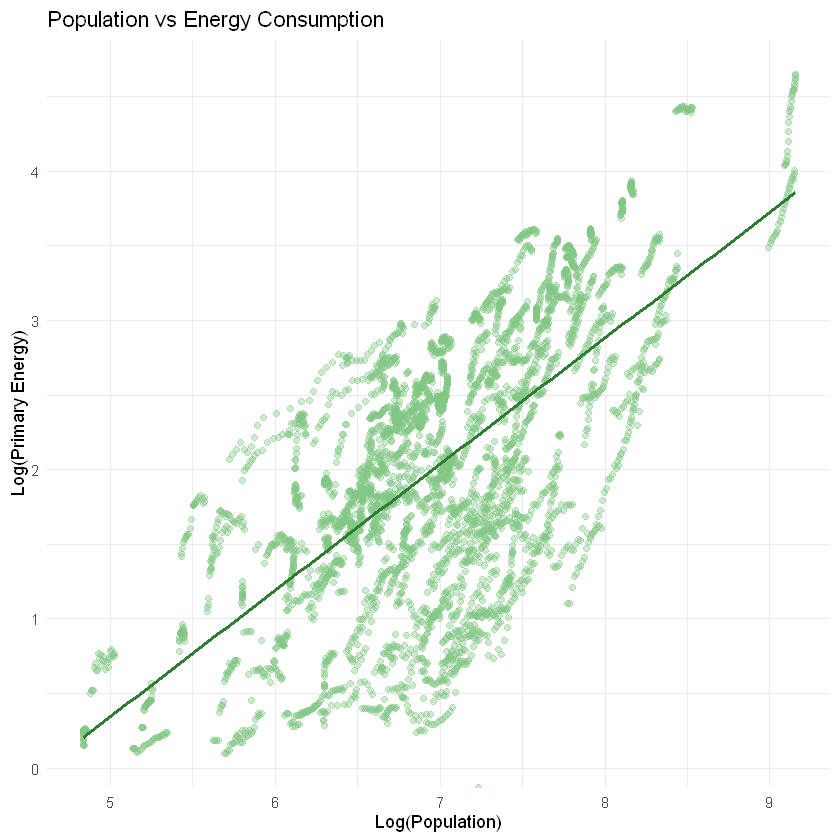

In [24]:
ggplot(energy_econ, aes(x = log_population, y = log_energy)) +
  geom_point(alpha = 0.4, color = "#81C784") +
  geom_smooth(method = "lm", se = FALSE, color = "#2E7D32") +
  theme_minimal() +
  labs(title = "Population vs Energy Consumption",
       x = "Log(Population)", y = "Log(Primary Energy)")


Population size correlates moderately with total energy use - more people generally imply higher demand, though wealth remains the stronger driver.

#### Correlation Insights

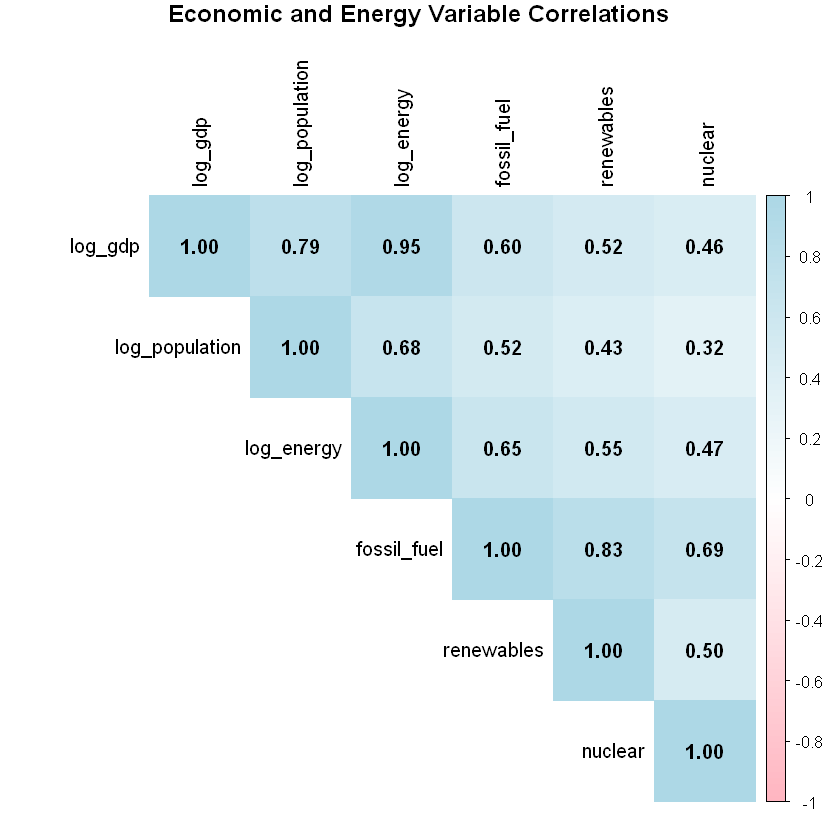

In [25]:

energy_econ_clean <- energy_econ %>%
  mutate(
    
    log_energy = ifelse(is.infinite(log_energy), NA, log_energy)
  ) %>%
  
  filter(!if_all(c(log_gdp, log_population, log_energy, fossil_fuel, renewables, nuclear), is.na))

# Now compute correlation
econ_corr <- energy_econ_clean %>%
  select(log_gdp, log_population, log_energy, fossil_fuel, renewables, nuclear) %>%
  cor(use = "pairwise.complete.obs")

# Plot
corrplot(
  econ_corr,
  method = "color",
  type = "upper",
  addCoef.col = "black",
  tl.col = "black",
  col = colorRampPalette(c("lightpink", "white", "lightblue"))(100),
  title = "Economic and Energy Variable Correlations",
  mar = c(0, 0, 1, 0)
)


Correlations confirm that:
- **GDP ↔ Energy:** very strong (≈ 0.95)  
- **Population ↔ Energy:** moderate (≈ 0.6)  
- **Fossil fuels ↔ GDP:** high dependency  
- **Renewables:** weak correlation - adoption driven by policy, not wealth alone.

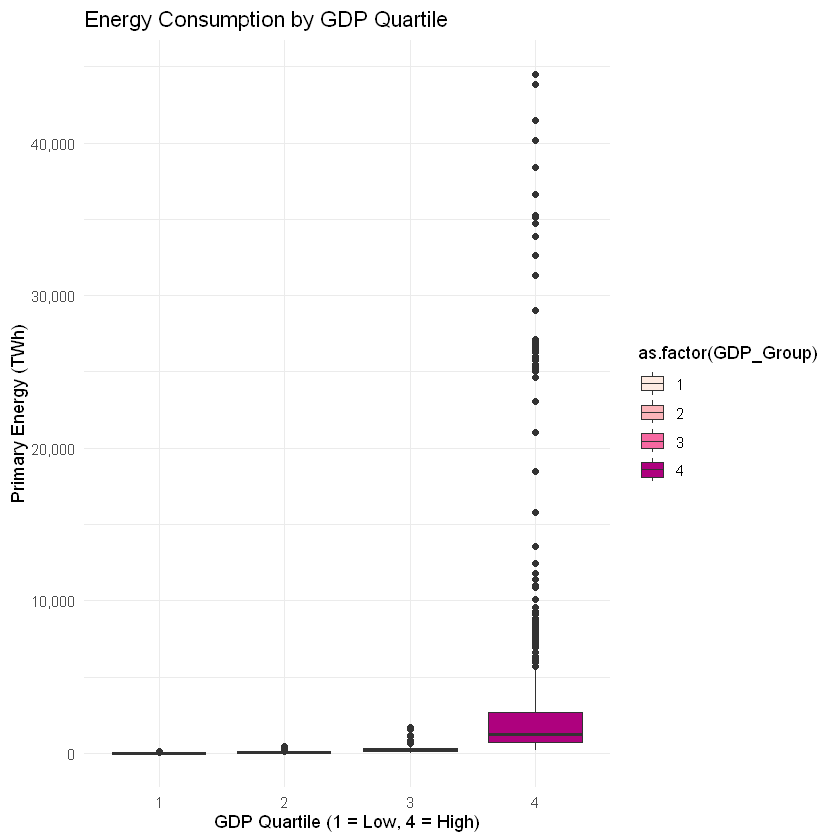

In [26]:
ggplot(energy_econ %>% mutate(GDP_Group = ntile(gdp, 4)),
       aes(x = as.factor(GDP_Group), y = primary_energy, fill = as.factor(GDP_Group))) +
  geom_boxplot() +
  scale_y_continuous(labels = comma) +
  scale_fill_brewer(palette = "RdPu") +
  theme_minimal() +
  labs(title = "Energy Consumption by GDP Quartile",
       x = "GDP Quartile (1 = Low, 4 = High)", y = "Primary Energy (TWh)")


Energy consumption increases consistently with GDP level, especially between middle- and high-income brackets — reflecting industrialization effects.


Together, these analyses show that:
- The 2010 global energy system was **fossil-dominated** with strong regional contrasts.  
- **Economic growth** remains the main engine of energy demand, while **population** plays a secondary role.  
- Wealthier economies exhibit **greater energy efficiency**, reflecting technological and policy evolution.  


##### These insights set the stage for country-specific trend exploration, such as **Japan vs South Korea**, where policy and innovation shape long-term energy transitions.

In [27]:
## Economic and Demographic Drivers of Energy Use

# Prepare dataset
energy_econ <- energy %>%
  select(country, year, population, gdp, primary_energy) %>%
  filter(!is.na(primary_energy), !is.na(gdp), !is.na(population))

# Categorize GDP into 4 quartiles for comparison
energy_econ <- energy_econ %>%
  mutate(
    gdp_category = ntile(gdp, 4),
    gdp_category = factor(gdp_category,
                          labels = c("Low", "Medium", "High", "Very High"))
  )



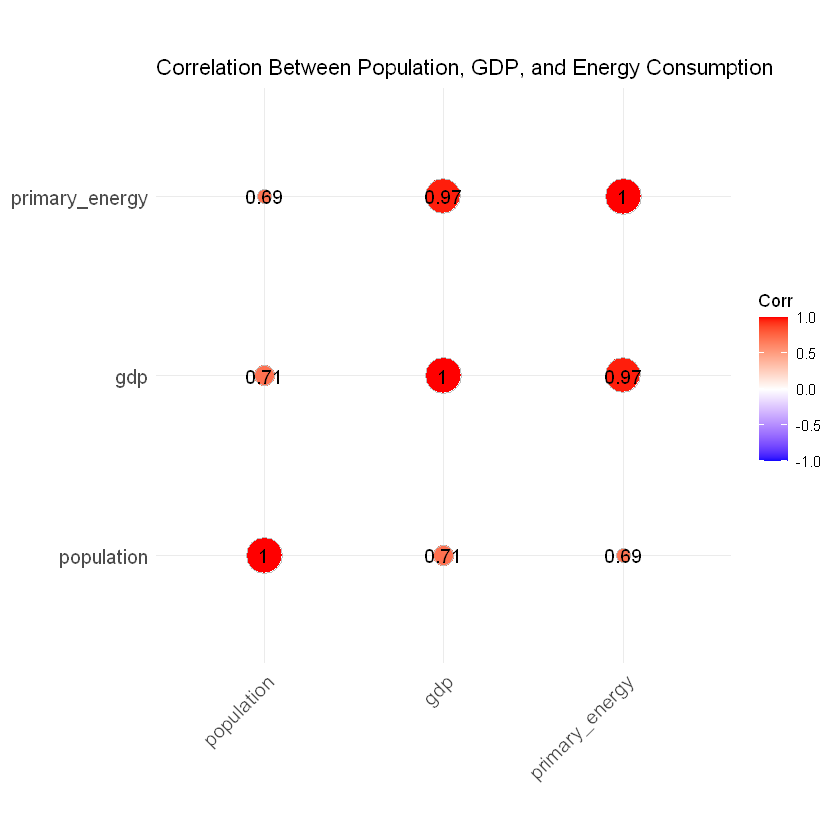

In [28]:
# Correlation between GDP, population, and energy use
library(ggcorrplot)

econ_corr <- energy_econ %>%
  select(population, gdp, primary_energy) %>%
  cor(use = "pairwise.complete.obs")

ggcorrplot(
  econ_corr,
  method = "circle",
  type = "full",
  lab = TRUE,
  title = "Correlation Between Population, GDP, and Energy Consumption",
  lab_size = 4,
  colors = c("blue", "white", "red")
)


### Interpretation
Correlation Plot - Quantitative Relationships
- GDP ↔ Energy: very strong (≈ 0.97).
- Population ↔ Energy: moderate (≈ 0.69).
- Confirms economic scale outweighs population in explaining energy demand.

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in scale_y_log10(labels = comma):
"log-10 transformation introduced infinite values."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`)."


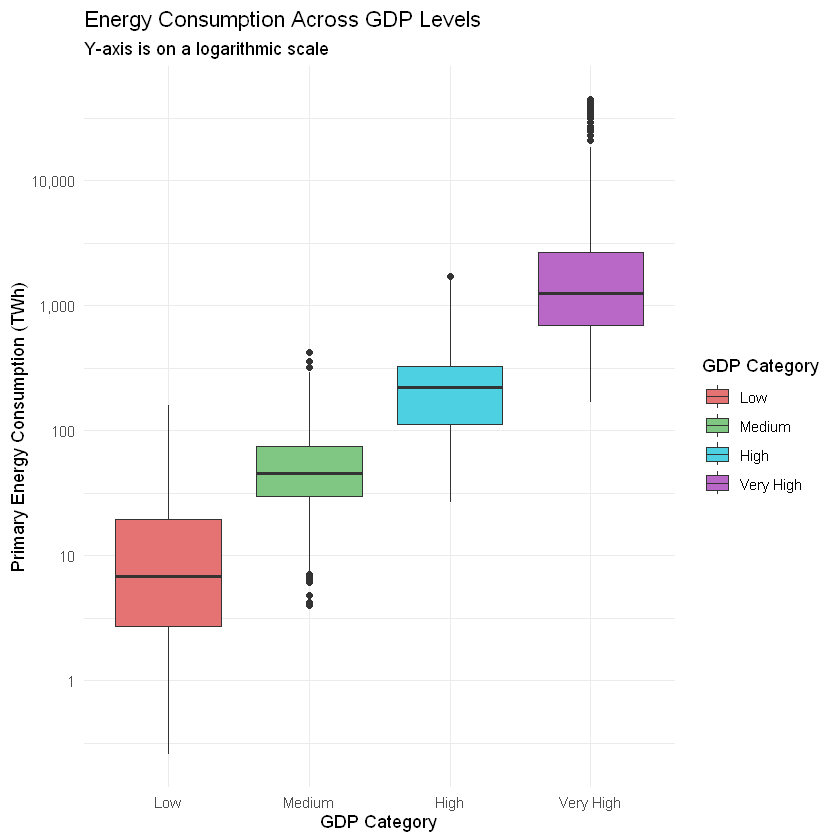

In [29]:
suppressWarnings({ggplot(energy_econ, aes(x = gdp_category, y = primary_energy, fill = gdp_category)) +
  geom_boxplot() +
  scale_y_log10(labels = comma) + # Use log scale to handle skew
  scale_fill_manual(values = c("#E57373", "#81C784", "#4DD0E1", "#BA68C8")) +
  theme_minimal() +
  labs(
    title = "Energy Consumption Across GDP Levels",
    subtitle = "Y-axis is on a logarithmic scale",
    x = "GDP Category",
    y = "Primary Energy Consumption (TWh)",
    fill = "GDP Category"
  )})

### Interpretation
Box Plot - Energy Consumption by GDP Level
- Median and variance of energy use rise sharply with GDP.
- Indicates a strong stratification effect of economic level.
- Right-skewed spread in low-GDP groups shows uneven energy access.

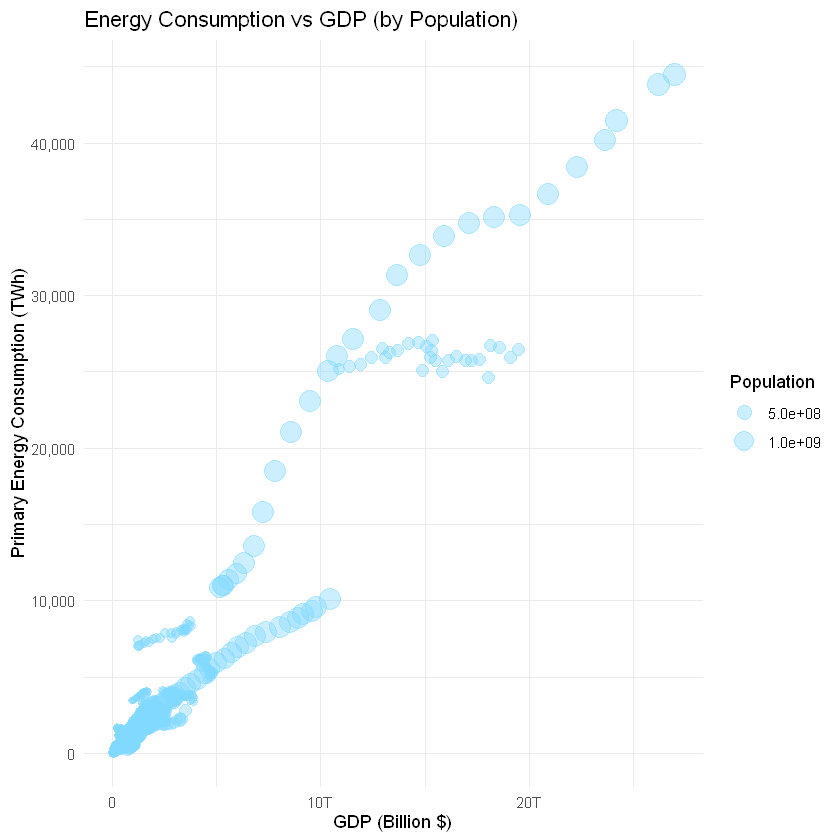

In [30]:
# GDP vs Energy consumption (bubble plot by population)
ggplot(energy_econ, aes(x = gdp, y = primary_energy, size = population)) +
  geom_point(alpha = 0.4, color = "#80D8FF") +
  scale_x_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  labs(
    title = "Energy Consumption vs GDP (by Population)",
    x = "GDP (Billion $)",
    y = "Primary Energy Consumption (TWh)",
    size = "Population"
  )


### Interpretation
Bubble Chart - Energy Consumption vs GDP (by Population)
- Shows a strong positive, nonlinear GDP-energy relationship.
- Population (bubble size) adds heteroskedasticity-larger nations consume more energy.
- Confirms joint economic and demographic influence on energy demand.

Economic scale exerts a much stronger influence on energy use than population size.  
Wealthier economies consume vastly more energy but also show signs of improved efficiency.  

Having established global drivers of energy demand, we now focus on **two developed Asian nations - Japan and South Korea -** to observe how policy and technology have shaped their long-term energy trajectories.

---
## Comparative Energy Trends: Japan vs South Korea (1996-2023)

This section analyzes and compares **energy consumption trends (1996-2023)** between **South Korea** and **Japan**, focusing on the evolution of fossil fuels, nuclear, renewables, and total primary energy use.

The goal is to understand how these two industrialized Asian economies have sourced and diversified their energy portfolios over time - particularly in response to major policy and historical events.


In [31]:
# Filter dataset for Japan and South Korea
asia_energy <- energy %>%
  filter(country %in% c("Japan", "South Korea")) %>%
  select(country, year, fossil_fuel, nuclear, renewables, primary_energy) %>%
  drop_na()

head(asia_energy)


,country,year,fossil_fuel,nuclear,renewables,primary_energy
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Japan,1996,4912.344,841.326,275.744,6029.414
2,Japan,1997,4928.647,911.288,307.030,6146.964
3,Japan,1998,4810.501,924.956,314.224,6049.681
4,Japan,1999,4943.913,900.159,299.939,6144.011
5,Japan,2000,5046.459,905.512,301.353,6253.323
6,Japan,2001,4990.448,903.625,291.630,6185.704


We focus on four key energy types - **Fossil fuels**, **Nuclear**, **Renewables**, and **Primary energy**.  
The timeline (1996–2023) captures events such as Japan’s **2011 Fukushima nuclear disaster** and South Korea’s **renewable transition policies**.


### Primary Energy Trends Over Time

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


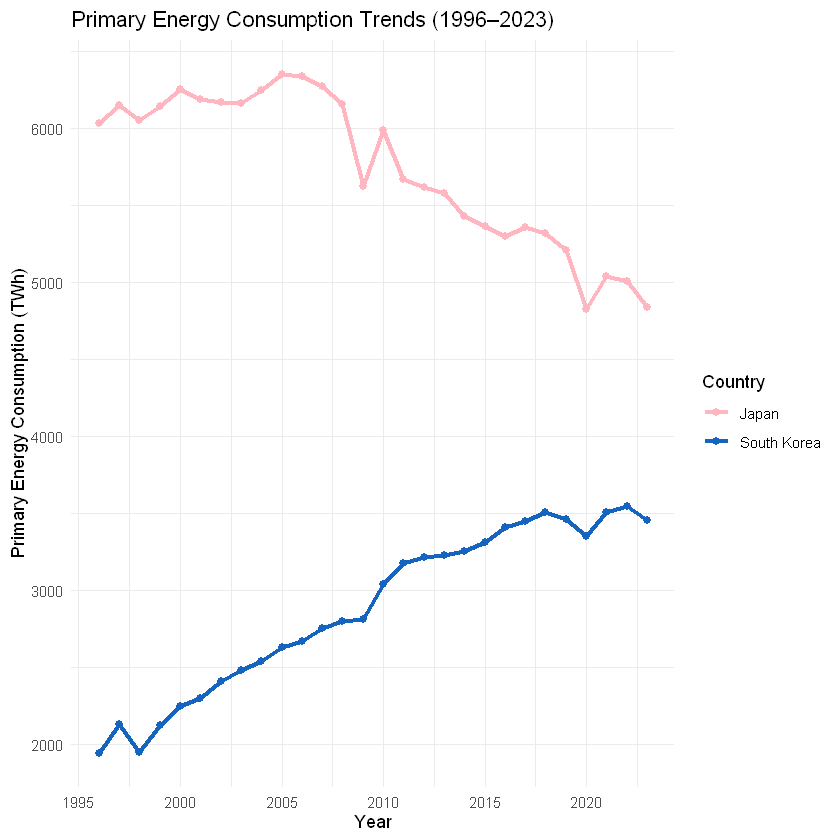

In [32]:
ggplot(asia_energy, aes(x = year, y = primary_energy, color = country)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  theme_minimal() +
  scale_color_manual(values = c("Japan" = "#FFB6C1", "South Korea" = "#1565C0")) +
  labs(
    title = "Primary Energy Consumption Trends (1996–2023)",
    x = "Year",
    y = "Primary Energy Consumption (TWh)",
    color = "Country"
  )


**Interpretation:**  
- **Japan:** Energy consumption peaked in the mid-2000s, then dropped sharply after **2011**, aligning with nuclear shutdowns and reduced industrial demand.  
- **South Korea:** Displays a consistent upward trend, reflecting rapid industrialization and rising energy intensity.


## Energy Source Composition

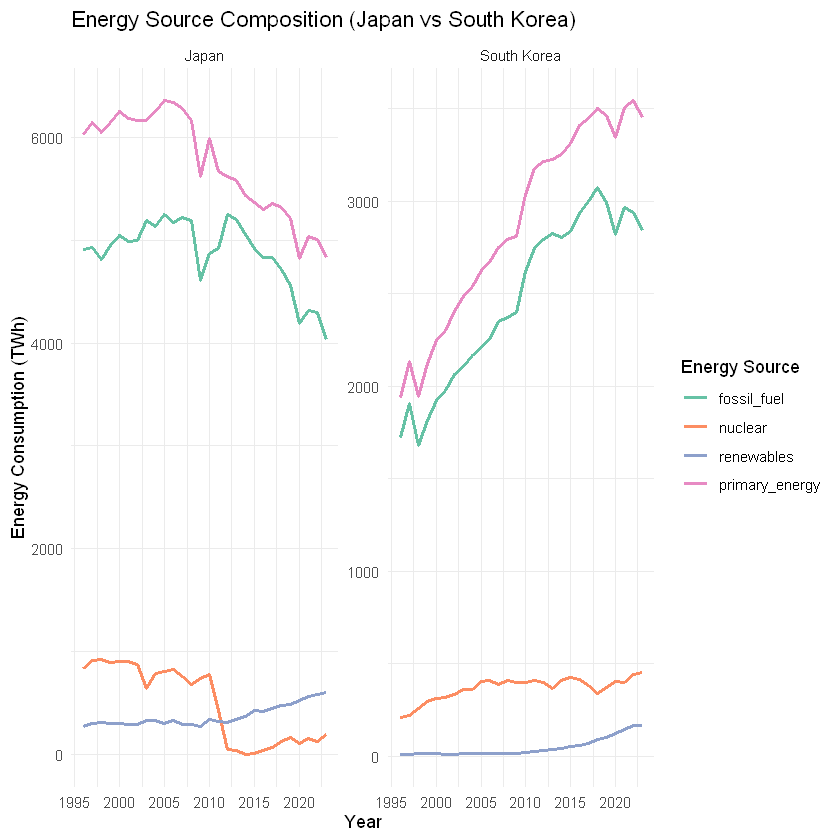

In [33]:
# Reshape data for source-wise comparison
asia_melt <- melt(asia_energy, id.vars = c("country", "year"),
                  variable.name = "Energy_Type", value.name = "Consumption")

ggplot(asia_melt, aes(x = year, y = Consumption, color = Energy_Type)) +
  geom_line(size = 1.1) +
  facet_wrap(~country, scales = "free_y") +
  theme_minimal() +
  scale_color_brewer(palette = "Set2") +
  labs(
    title = "Energy Source Composition (Japan vs South Korea)",
    x = "Year",
    y = "Energy Consumption (TWh)",
    color = "Energy Source"
  )


**Insights:**  
- Both nations depend heavily on **fossil fuels**, though trends differ.  
- **Japan:** Experienced a collapse in **nuclear energy** post-2011, partially offset by slow renewable growth.  
- **South Korea:** Shows a more **balanced diversification**, maintaining nuclear output while expanding renewables steadily.


## Growth of Renewable Energy


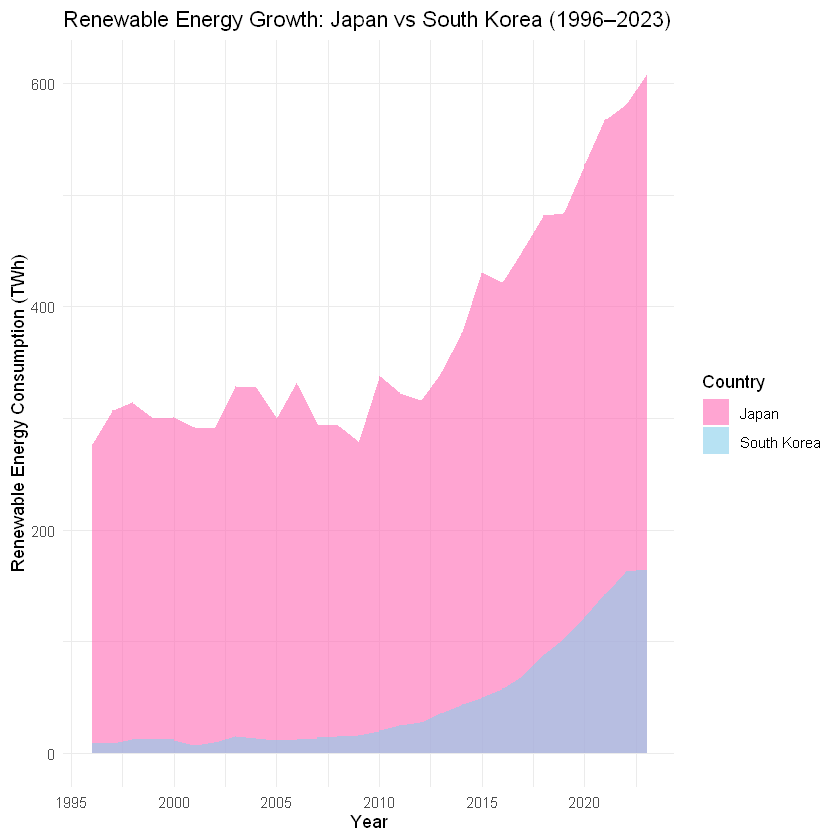

In [34]:
ggplot(asia_energy, aes(x = year, y = renewables, fill = country)) +
  geom_area(alpha = 0.6, position = "identity") +
  scale_fill_manual(values = c("Japan" = "#FF69B4", "South Korea" = "#87CEEB")) +
  theme_minimal() +
  labs(
    title = "Renewable Energy Growth: Japan vs South Korea (1996–2023)",
    x = "Year",
    y = "Renewable Energy Consumption (TWh)",
    fill = "Country"
  )


**Observations:**  
- Both nations had negligible renewable energy use before 2005.  
- **South Korea** shows a steady and continuous increase post-2010, linked to its **Green Growth Strategy**.  
- **Japan** accelerated renewable adoption only after 2011, but growth has remained gradual.


Japan’s energy profile shows the clear impact of the **Fukushima disaster**, leading to reduced nuclear reliance and slower renewable substitution.  
South Korea’s energy evolution, on the other hand, reflects **policy-driven diversification** while maintaining industrial expansion.

Both countries highlight the **strategic tension** between energy security, sustainability, and industrial dependency - a core theme in global energy transition discussions.


The comparative analysis underscores that:

- **Economic maturity** alone does not guarantee cleaner energy - **policy choices** are equally decisive.  
- **South Korea’s** proactive diversification strategy yielded more resilient energy growth.  
- **Japan’s** post-Fukushima phase marks a critical inflection, with gradual renewable recovery but persistent fossil reliance.  
- The evolution of both nations reveals how **industrialized economies manage energy transitions under crisis and reform.**

Together, these insights bridge the global patterns seen earlier with **real-world national trajectories**, illustrating how macroeconomic trends translate into country-specific energy pathways.
